In [1]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
from matplotlib.pyplot import plot
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
import math

In [2]:
def show(img):
    plt.figure(figsize=(7,7))
    plt.imshow(img, cmap='gray')

In [3]:
def norm_img(img, m_const=1.0):
    return (m_const*(img-img.min())/(img.max()-img.min()))

def cut_img(img):
    copy = img
    copy[copy<0] = 0
    copy[copy>255] = 255
    return copy

def transform_img(img):
    laplacian_img_cut = cut_img(cv2.Laplacian(255-img, ddepth = cv2.CV_16U, ksize = 3))
    laplacian_img = norm_img(cv2.Laplacian(img, ddepth = cv2.CV_16U, ksize = 3), 255.0).astype('int')
    laplacian_img = (255*np.power(laplacian_img/255, 0.5)).astype('uint8')
    laplacian_img_sharp = norm_img(img+laplacian_img_cut, 255.0).astype('uint8')
    sobel_x = cv2.Sobel(img , ddepth=cv2.CV_16U, dx = 1, dy = 0)
    sobel_y = cv2.Sobel(img , ddepth=cv2.CV_16U, dx = 0, dy = 1)
    sobel = np.absolute(sobel_x) + np.absolute(sobel_y)
    sobel_img = cut_img(img+sobel)
    sobel_blur = cv2.blur(sobel_img, (5,5))
    mask = norm_img(cv2.multiply(laplacian_img_sharp, sobel_blur, dtype = cv2.CV_16U), 255.0).astype('int')
    mask_sharp = cut_img(img + mask)
    res = (255*np.power(mask_sharp/255, 2.5)).astype('uint8')
    return(res)

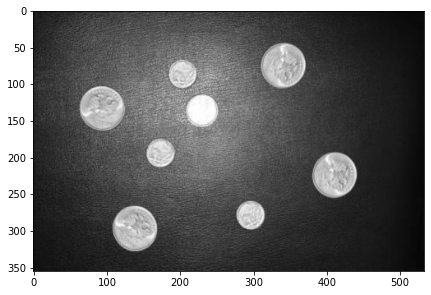

In [4]:
img = cv2.imread('coins.png')
show(img)

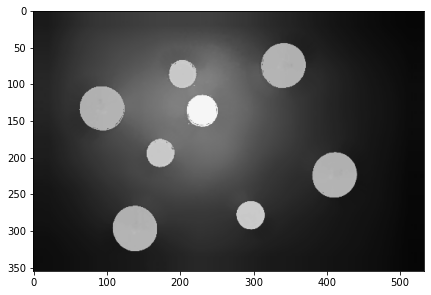

In [5]:
shift_img = (255*np.power(cv2.pyrMeanShiftFiltering(img, 21, 51)/255, 1.2)).astype('uint8')
show(shift_img)

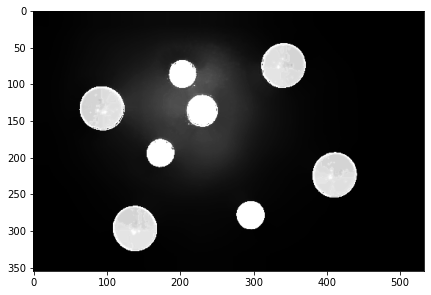

In [6]:
trans_img = transform_img(shift_img)
show(trans_img)

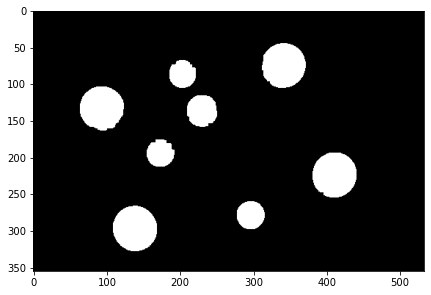

In [7]:
gray = cv2.cvtColor(trans_img, cv2.COLOR_RGB2GRAY)
binary = cv2.THRESH_BINARY
thresh = cv2.threshold(gray, 60, 255, binary+cv2.THRESH_OTSU)[1]
kernel = np.ones((3,3), np.uint8)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 3)
show(thresh)

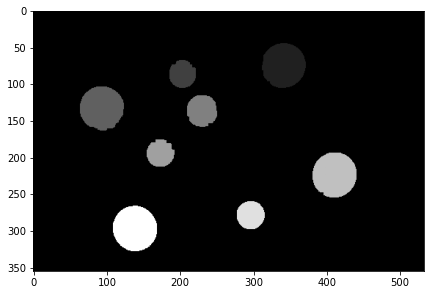

In [8]:
_, labels = cv2.connectedComponents(thresh)
show(labels)

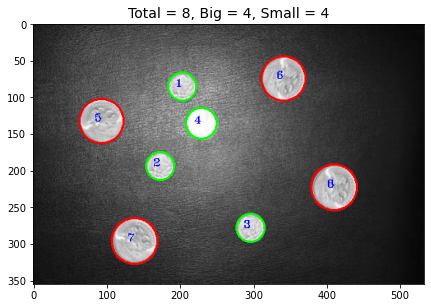

In [10]:
rad_list = []
coord_list = []
for label in np.unique(labels):
    if label == 0:
        continue
    mask = np.zeros(gray.shape, dtype = 'uint8')
    mask[labels == label] = 255
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    ((x,y), r) = cv2.minEnclosingCircle(c)
    if r>15:
        rad_list.append(r)
        coord_list.append((x,y))
rad_list = np.array(rad_list)
coord_list = np.array(coord_list)
indices = rad_list.argsort()
rad_list = rad_list[indices[::1]]
coord_list = coord_list[indices[::1]]
border_val_id = np.argmax(np.diff(rad_list)) + 1
res_img = img.copy()
color = (0,255,0)
for i, r in enumerate(rad_list):
    (x,y) = coord_list[i]
    if i == border_val_id:
        color = (255, 0, 0)
    cv2.circle(res_img, (int(x), int(y)), int(r), color, 2)
    cv2.putText(res_img, f"{i+1}", (int(x)-10, int(y)), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0,0,255), 0)
total_coins = len(rad_list)
plt.figure(figsize=(7,7))
plt.imshow(res_img)
plt.title(f"Total = {len(rad_list)}, Big = {len(rad_list) - border_val_id}, Small = {border_val_id}", fontsize = 14)
plt.show()